## Data Conversion: Validation

Let's make kinematic plots & get images from our converted data. I think we have such code elsewhere but this is also a nice way for me to continue on the `uproot3` $\rightarrow$ `uproot4` transition.

In [1]:
#import libraries and some constants
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ROOT as rt # I will use this for some plotting
import uproot as ur
import awkward as ak

path_prefix = os.getcwd() + '/../../'

if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu
from util import qol_util as qu

from util.classification import plot_util as cpu

rt.gStyle.SetOptStat(0)
ps = qu.PlotStyle('dark')
ps.SetStyle()

Welcome to JupyROOT 6.22/02


In [2]:
unconverted_data_dir = path_prefix + 'data/pion2_graph'
converted_data_dir   = path_prefix + 'data/pion2'

unconverted_data_dir = path_prefix + 'data/pion2_i'
converted_data_dir   = path_prefix + 'data/pion2_o'

data_filenames = {
    'unconv': glob.glob(unconverted_data_dir + '/**/*.root',recursive=True),
    'conv'  : glob.glob(converted_data_dir   + '/**/*.root',recursive=True)
}

In [3]:
# Define a bunch of histograms for kinematics
type_keys = ['conv','unconv']

cluster_vars = ['cluster_Pt','cluster_Eta','cluster_Phi','cluster_ENG_CALIB_TOT']
jet_vars     = ['AntiKt4LCTopoJetsPt','AntiKt4LCTopoJetsEta','AntiKt4LCTopoJetsPhi','AntiKt4LCTopoJetsE']

data_ranges = {
    'cluster_Pt':(100,0.,100.),
    'cluster_Eta':(100,-2.,2.),
    'cluster_Phi':(100,-2. * np.pi, 2. * np.pi),
    'cluster_ENG_CALIB_TOT':(100,0.,100.),
    'AntiKt4LCTopoJetsPt':(100,0.,1000.),
    'AntiKt4LCTopoJetsEta':(100,-2.,2.),
    'AntiKt4LCTopoJetsPhi':(100,-2. * np.pi, 2. * np.pi),
    'AntiKt4LCTopoJetsE': (100,0.,1000.)
}

kinematic_hists = {
    key:{
        key2:rt.TH1F(qu.RN(),key2,*val)
        for key2,val in data_ranges.items()
    }
    for key in type_keys
}

In [4]:
for type_key in type_keys:
    
    for data_filename in data_filenames[type_key]:
#         if(data_filename != data_filenames[type_key][0]): continue
        ur_file = ur.open(data_filename)

        # Deal with cluster-level kinematic variables.
        # How they are stored depends on whether this is a converted or unconverted file.
        if(type_key == 'conv'): tree_key = 'ClusterTree'
        else: tree_key = 'EventTree'
        for cluster_var in cluster_vars:
            vals = ak.flatten(ur_file[tree_key][cluster_var].array(),axis=None).to_numpy()
            [kinematic_hists[type_key][cluster_var].Fill(x) for x in vals]
            
        # Deal with event-level kinematic variables (jets).
        for jet_var in jet_vars:
            vals = ak.flatten(ur_file['EventTree'][jet_var].array(),axis=None).to_numpy()
            [kinematic_hists[type_key][jet_var].Fill(x) for x in vals]

        ur_file.close()

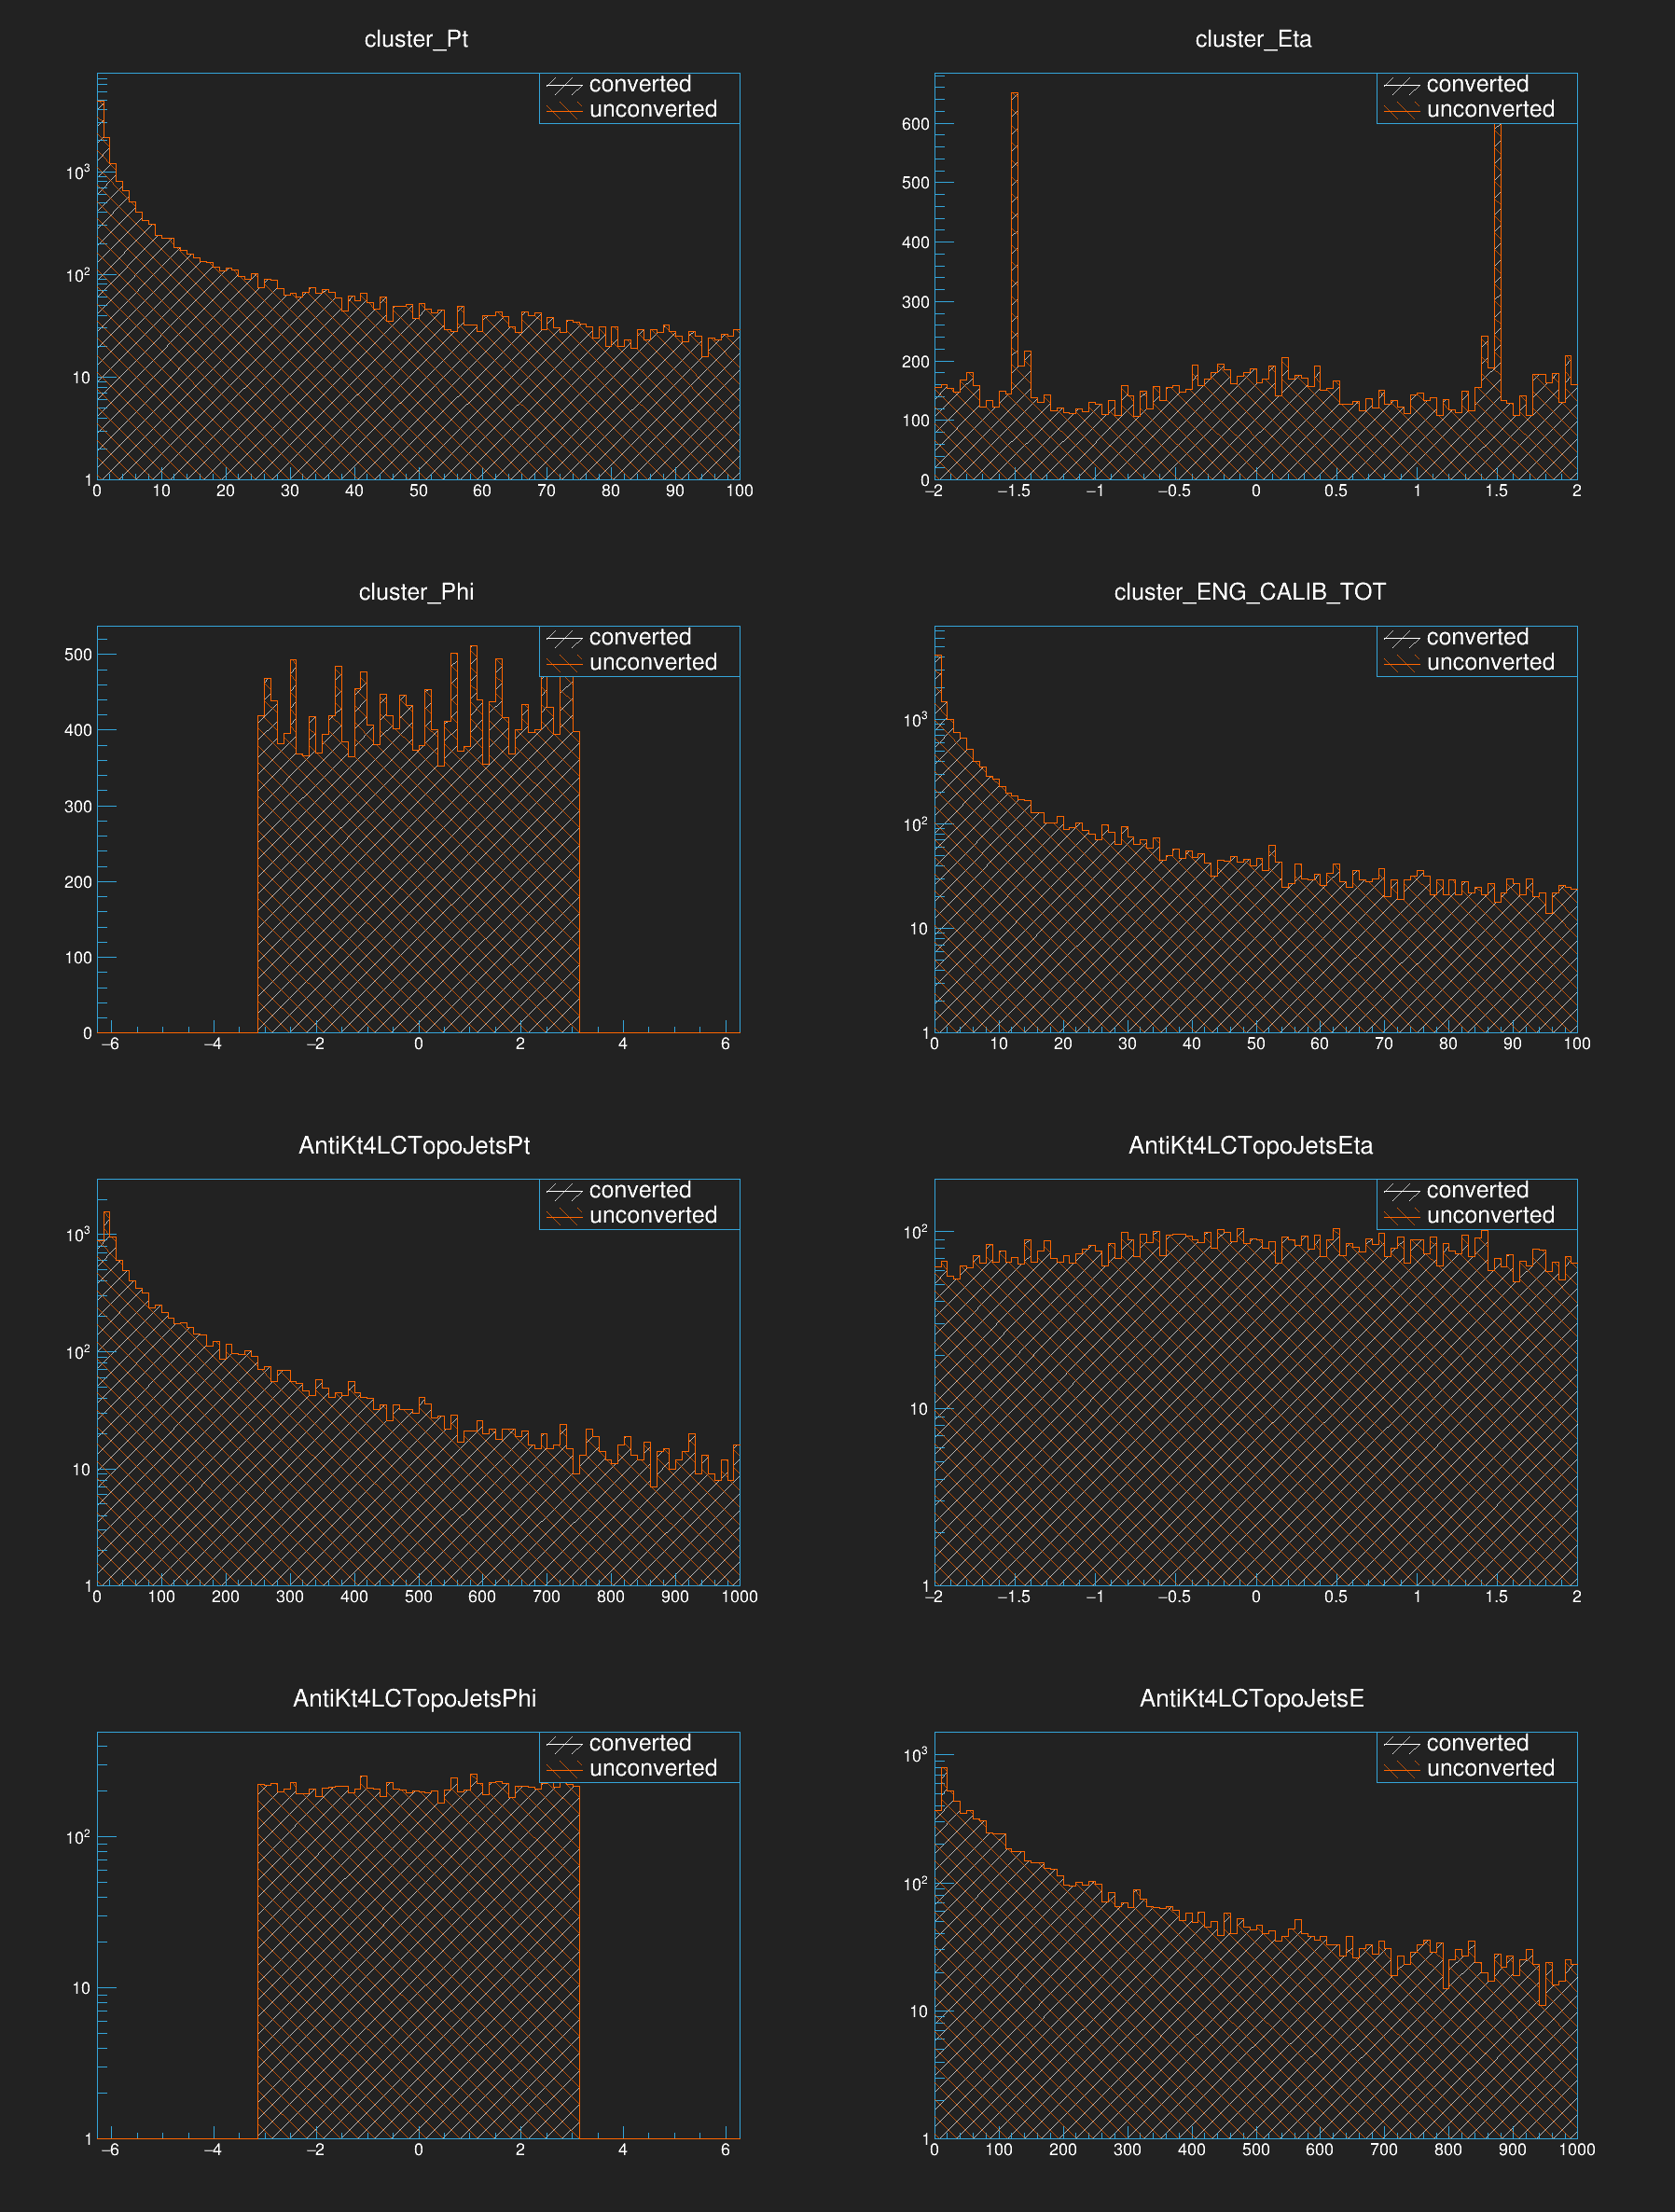

In [5]:
canv = rt.TCanvas(qu.RN(),'c1',1800,2400)
canv.Divide(2,4)

leg = rt.TLegend(0.65,0.8,0.9,0.9)
leg.SetTextColor(ps.text)
leg.SetTextSize(0.05)

colors = {'unconv':ps.curve, 'conv':ps.text}
fills  = {'unconv':3545, 'conv':3554}
names  = {'unconv':'unconverted', 'conv':'converted'}

for key in type_keys:
    leg.AddEntry(list(kinematic_hists[key].values())[0],names[key],'lf')

for key in type_keys:
        
    for i,hist in enumerate(kinematic_hists[key].values()):
        canv.cd(i+1) # 1-indexing
        hist.SetLineColor(colors[key])
        hist.SetFillColorAlpha(colors[key],0.7)
        hist.SetFillStyle(fills[key])
        hist.Draw('HIST SAME')
        if(i in [0,3,4,5,6,7]): 
            rt.gPad.SetLogy()
            hist.SetMinimum(1.)
        else:
            hist.SetMinimum(0.)
            
        leg.Draw()        
             
canv.Draw()

Now let's look at the (average) calorimeter images. We only have these in the converted file (the whole reason we did the conversion).

In [6]:
layers = list(mu.cell_meta.keys())

calo_images = {
    layer:rt.TH2F(
        qu.RN(),
        '{} (average)'.format(layer),
        mu.cell_meta[layer]['len_eta'],
        - mu.cell_meta[layer]['cell_size_eta'] * mu.cell_meta[layer]['len_eta'] / 2.,
          mu.cell_meta[layer]['cell_size_eta'] * mu.cell_meta[layer]['len_eta'] / 2.,
        mu.cell_meta[layer]['len_phi'],
        - mu.cell_meta[layer]['cell_size_phi'] * mu.cell_meta[layer]['len_phi'] / 2.,
          mu.cell_meta[layer]['cell_size_phi'] * mu.cell_meta[layer]['len_phi'] / 2.,
    )
    for layer in layers
}

In [7]:
avg_images = {layer:np.zeros((mu.cell_meta[layer]['len_eta'],mu.cell_meta[layer]['len_phi'])) for layer in layers}
n_images = 0
for data_filename in data_filenames['conv']:
        ur_file = ur.open(data_filename)
        n_images += ur_file['ClusterTree'].num_entries
        for layer in layers:
            avg_images[layer] = avg_images[layer] + np.sum(ur_file['ClusterTree'][layer].array().to_numpy(),axis=0)
        ur_file.close()    
avg_images = {layer:avg_images[layer]/n_images for layer in layers}

In [8]:
for layer in layers:
    nx,ny = avg_images[layer].shape
    for i in range(nx):
        for j in range(ny):
            calo_images[layer].SetBinContent(i+1,j+1,avg_images[layer][i,j])
            

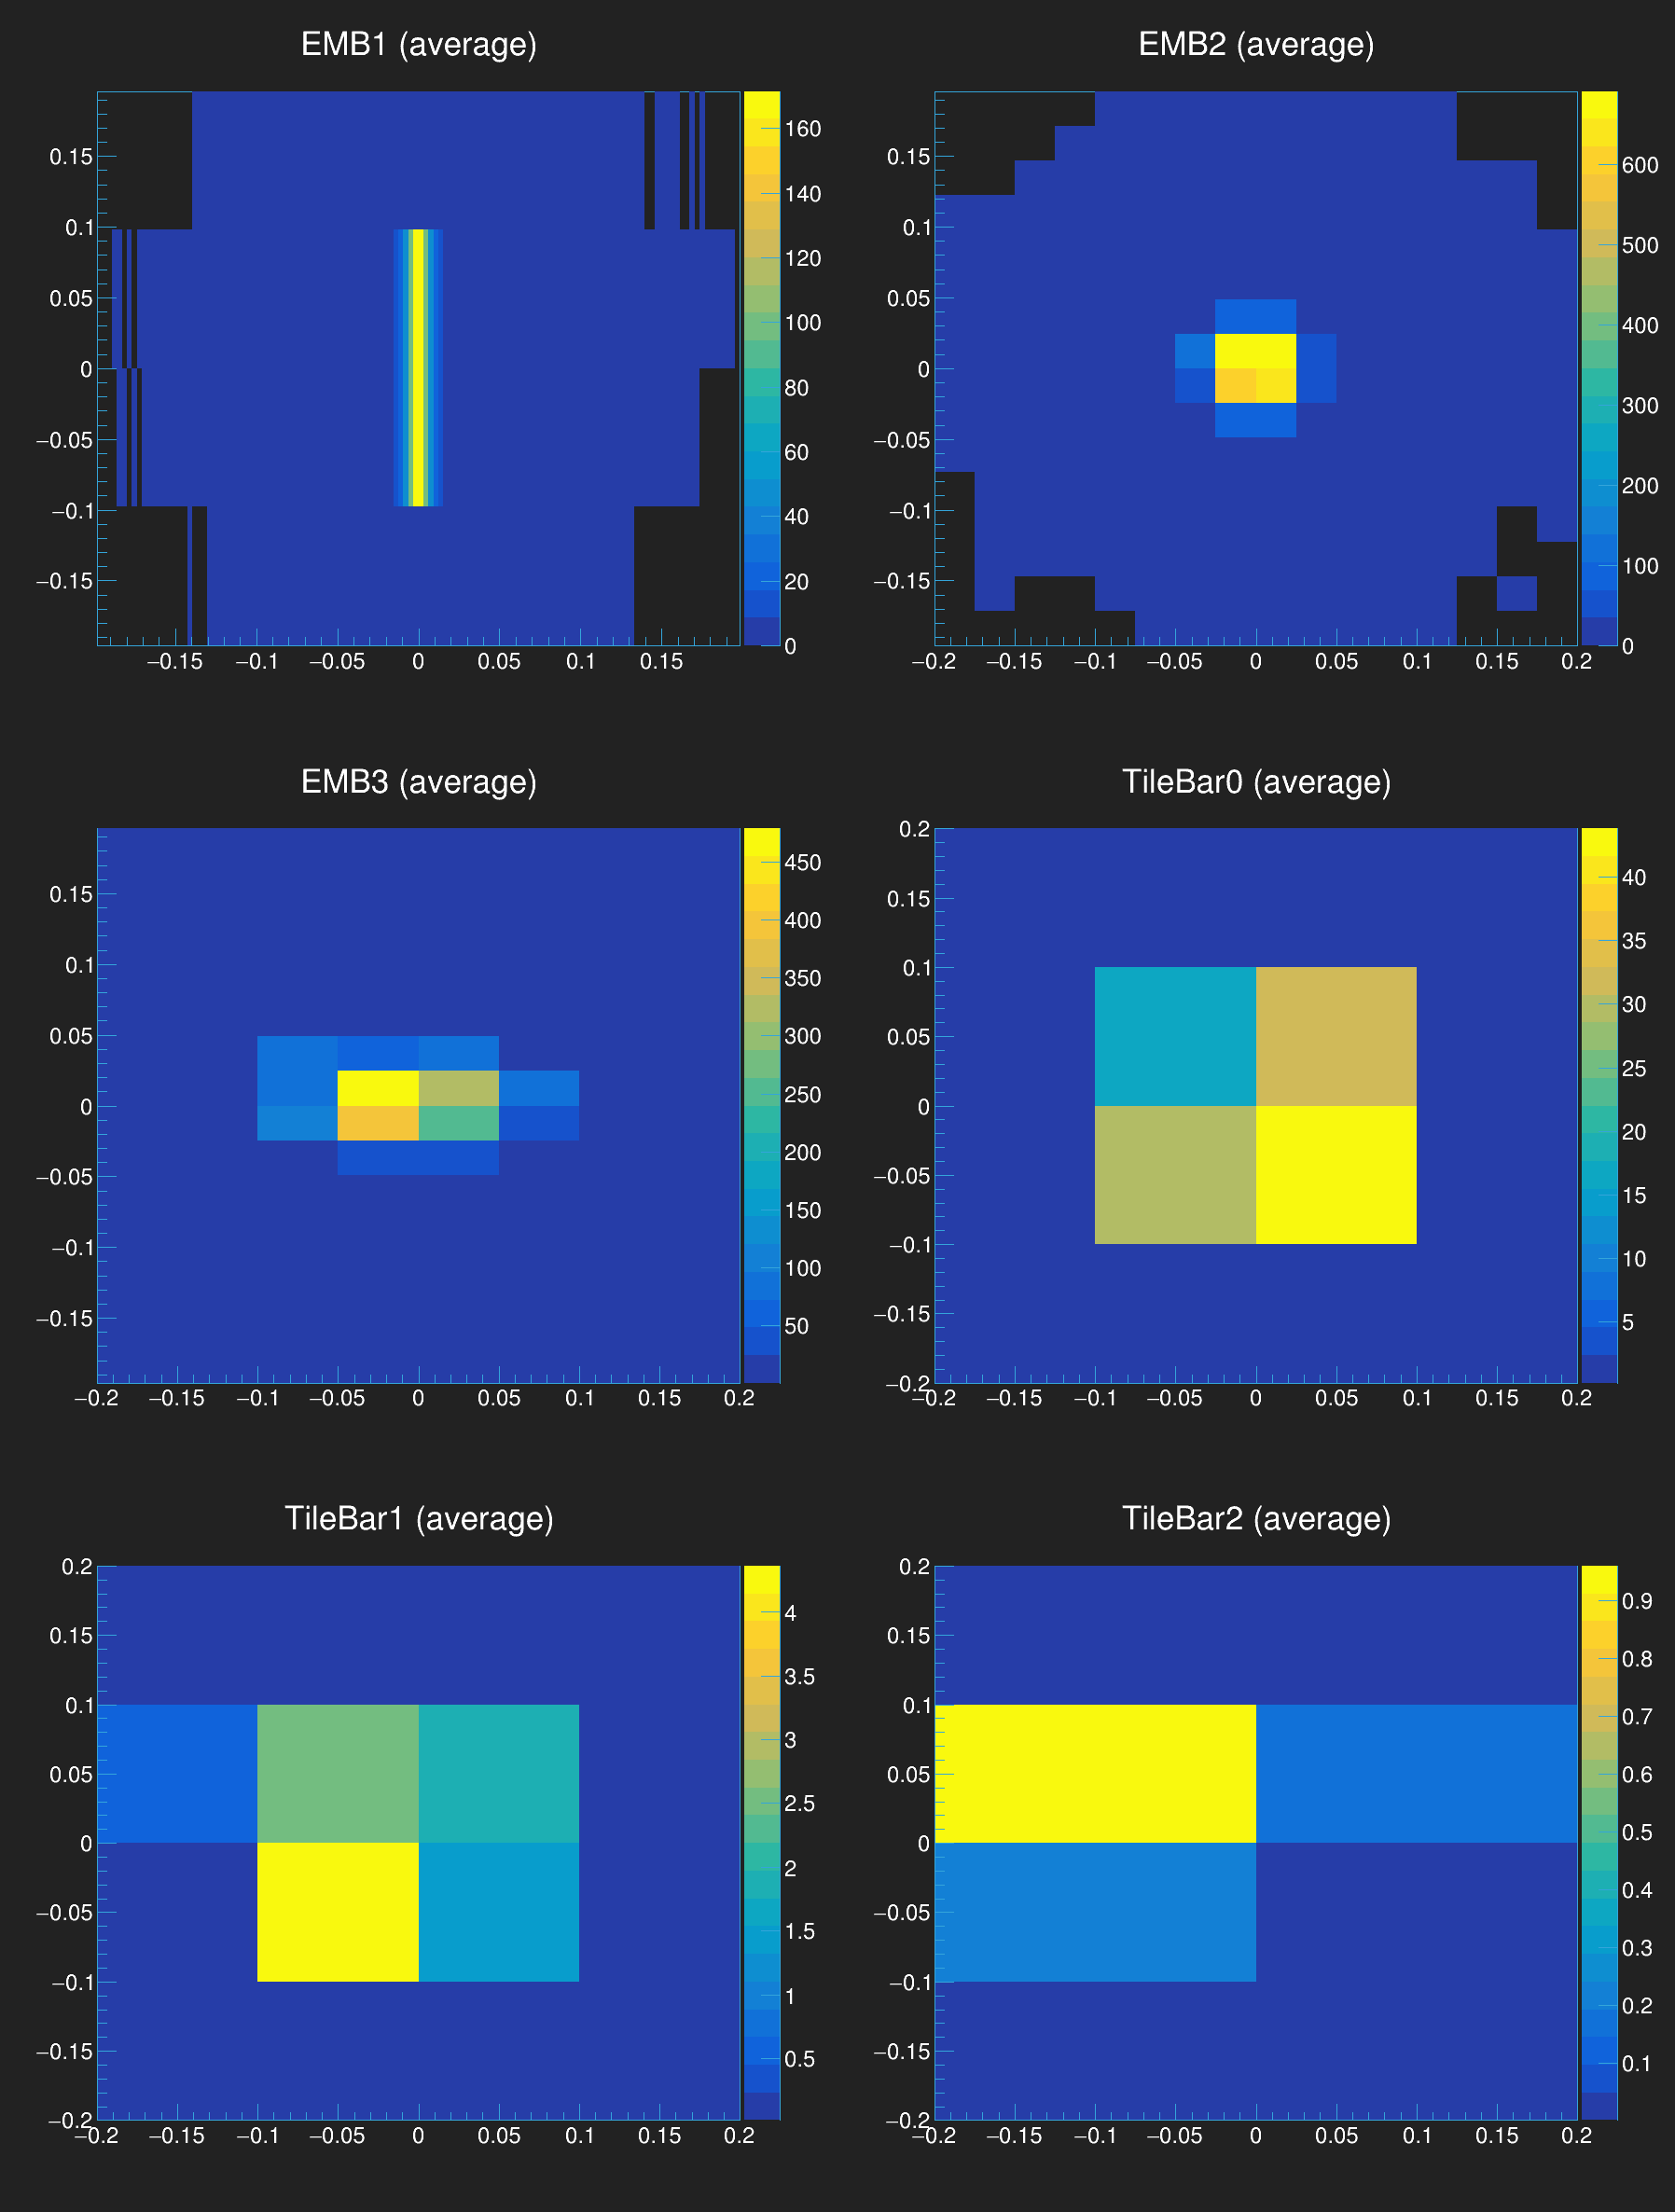

In [9]:
canv = rt.TCanvas(qu.RN(),'c1',1800,2400)
canv.Divide(2,3)

for i,layer in enumerate(layers):
    canv.cd(i+1)
    calo_images[layer].Draw("COLZ")
    
canv.Draw()

In [10]:
# scaled_shape = (16,16)
# cpu.ImagePlot(
#     pcells,
#     cluster=2,
#     layers=layers,
#     cell_shapes=[],
#     scaled_shape = scaled_shape,
#     plotpath=os.getcwd(),
#     filename='calo_images.png',
#     latex_mpl={'ims':'a'},
#     plotstyle=ps
# )